In [1]:
# imports and settings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

from torchinfo import summary

import pytorch_lightning as pl
from pytorch_lightning import Callback

from torchmetrics.classification import Accuracy

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import numpy as np
import pandas as pd
import math

from utils import PrintMetricsCallback

# Transfer Learning

The idea with transfer learning is to use a model that has already been trained on a dataset and to use that model as a starting point for our task.  We'll largely follow along with Chapter 13 of the textbook, but we'll use PyTorch lightning to manage the training and other tasks.

Along the way we'll learn about several things:

* How to use a dataset that isn't already a torchvision dataset using the PyTorch ImageFolder class
* One approach to dealing with irregularly sized images (they're not squares)
* One source for predefined and pretrained models (torchvision)
* How to adjust a predefined model for a new task
* How to use a learning rate scheduler during training

## Preparing an Image Dataset

This code will donwnload a cats and dog dataset that was once part of a [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats/data).  We'll check to see if the data has already been downloaded to avoid this step if possible.  After the data has been extracted the zip file is deleted.

In [2]:
data_url_zip = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

#Download this dataset if we have not already done so! 
if not os.path.isdir('./data/PetImages'):
    resp = urlopen(data_url_zip)
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall(path = './data')

#This file is bad and will screw up the data loader! 
bad_files = [
    './data/PetImages/Dog/11702.jpg',
    "./data/PetImages/Cat/666.jpg"
]
for f in bad_files:
    if os.path.isfile(f):
        os.remove(f)

The Kaggle competition provided a validation set, but the download above appears to be just the original training data.  In the cell below we'll set a desired image size, `imsize`, and

1.  Resize the image so the smallest dimension is `imsize`+2 pixels. For example, a 260 × 390 image would become (imsize+2) × y (y is chosen to maintain the original aspect ratio).
2. Crop out the center imsize × imsize pixels.
3.  Convert the image to a PyTorch tensor, which includes normalizing the pixel
values from [0, 255] to [0, 1].


In [3]:
imsize = 128
torch.manual_seed(42) 

all_images = ImageFolder("./data/PetImages", transform=transforms.Compose(
    [
        transforms.Resize(imsize+2), #The smallest of width/height will become 130 pixels. 
        transforms.CenterCrop(imsize), # Take the center 128 x 128 image
        transforms.ToTensor(), #Convert to a PyTorch tensor
    ]))

train_size = int(len(all_images)*0.8) #Pick 80% for training 
valid_size = len(all_images)-train_size #20% remainder for testing

train_data, valid_data = torch.utils.data.random_split(all_images, (train_size, valid_size)) #Create the random splits of the specified sizes

Now get the dataloaders:

In [4]:
B = 128
train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=B)

Let's view a few of the images to see how they came out:

In [5]:
valid_data[0]

(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.1255, 0.1255, 0.1294],
          [0.0039, 0.0039, 0.0039,  ..., 0.1216, 0.1216, 0.1216],
          [0.0039, 0.0039, 0.0039,  ..., 0.1176, 0.1176, 0.1216],
          ...,
          [0.1608, 0.1608, 0.1529,  ..., 0.3804, 0.3843, 0.4157],
          [0.1647, 0.1686, 0.1608,  ..., 0.4471, 0.4510, 0.4863],
          [0.1686, 0.1529, 0.1176,  ..., 0.5137, 0.5255, 0.5490]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.1294, 0.1333, 0.1373],
          [0.0039, 0.0039, 0.0039,  ..., 0.1294, 0.1294, 0.1294],
          [0.0039, 0.0039, 0.0039,  ..., 0.1255, 0.1294, 0.1294],
          ...,
          [0.1647, 0.1725, 0.1686,  ..., 0.4157, 0.4235, 0.4510],
          [0.1686, 0.1765, 0.1686,  ..., 0.4784, 0.4784, 0.5176],
          [0.1725, 0.1569, 0.1216,  ..., 0.5490, 0.5569, 0.5804]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.1294, 0.1294, 0.1333],
          [0.0039, 0.0039, 0.0039,  ..., 0.1255, 0.1255, 0.1255],
          [0.0039, 0.0039, 0.0039,  ...,

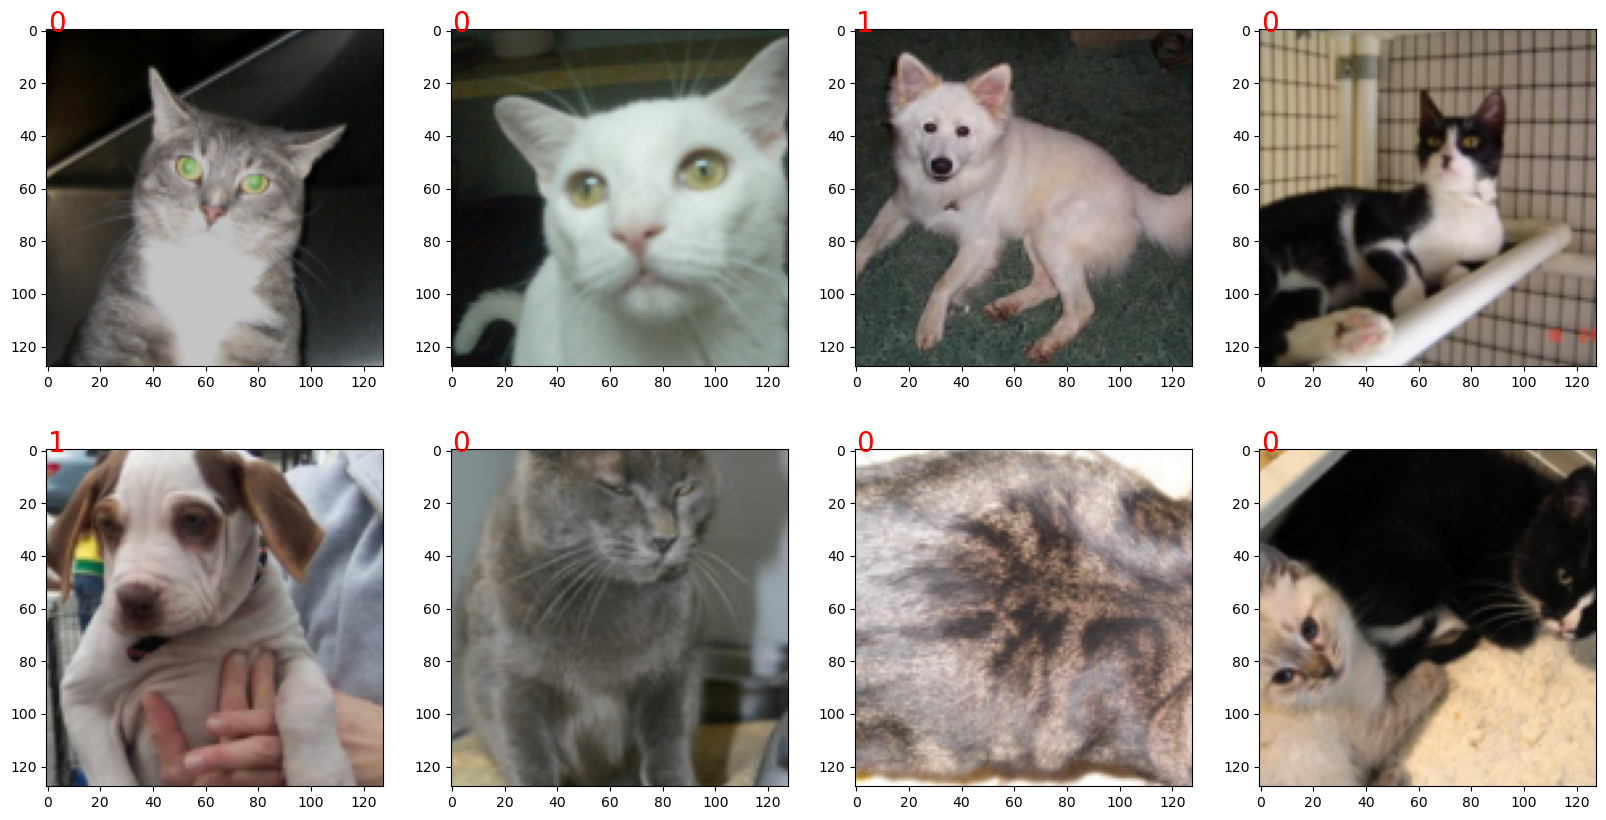

In [6]:
# code from textbook
f, axarr = plt.subplots(2,4, figsize=(20,10)) #Create a grid of 8 images (2 x 4)
for i in range(2): # Rows
    for j in range(4): #Columns
        x, y = valid_data[i*4+j] # Grab an image from the test corpus
        axarr[i,j].imshow(x.numpy().transpose(1,2,0)) #Plot the image 
        axarr[i,j].text(0.0, 0.5, str(round(y,2)), dict(size=20, color='red')) #Draw the label in the top left corner.

## Getting a model from torchvision.models

torchvision.models includes many different CNNs.  Each has been trained on [Imagenet](https://www.image-net.org/) which includes 14,192,122 images from 1,000 classes. 

To see a list of the models that are available for classification visit the [documentation](https://pytorch.org/vision/stable/models.html#classification).  Scroll down the page a bit to see all of the available pre-trained weights.

Note, since the book was published in 2022 the method for loading weights has changed.  It used to be that you could simply use

```
from torchvision.models import resnet18
model = resnet18(pretrained=True)
```

and you'll find this all over the internet as well.  However the new approach goes like in the following cell:

In [7]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

One nice thing about this approach is that the transforms need to apply to an image before sending it to the model are included with the weights.  We won't pay much attention to this right now, but we can see that the means and standard deviations we need to use to normalization are included:

In [8]:
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

As usual, we can see a summary of the layers like this:

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

If you look carefully you'll see the kind of convolutional blocks we've been studying in class.  You may also notice that there are some 1x1 convolution sprinkled in there for changing the number of channels.  It's difficult to see how the residual connections are made, but they're part of the model.  Two particular things to notice at the end of the model:

* `AdaptiveAvgPool2d` figures out the size of pooling to apply to produce a 1x1 output
* the fully connected layer at the end has 1000 output features so we'll need to change that since we have only two (cats and dogs)

We'll show how to fix that final layer shortly, but 

The ResNet models were designed to be applied to 224x224 input images, but we'll train with 64x64 images for demonstration.  Let's see how the model will handle a 64x64 image by using torchinfo.summary()

In [10]:
from torchinfo import summary # may need to run !pip install torchinfo in colab
summary(model, input_size = (B,3,64,64),
        col_names = ["input_size","output_size","num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [128, 3, 64, 64]          [128, 1000]               --
├─Conv2d: 1-1                            [128, 3, 64, 64]          [128, 64, 32, 32]         9,408
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         [128, 64, 32, 32]         128
├─ReLU: 1-3                              [128, 64, 32, 32]         [128, 64, 32, 32]         --
├─MaxPool2d: 1-4                         [128, 64, 32, 32]         [128, 64, 16, 16]         --
├─Sequential: 1-5                        [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    └─BasicBlock: 2-1                   [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 64, 16, 16]         [128, 64, 16, 16]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 16, 16]         [128, 64, 16, 16]         128
│    │    └─ReLU: 3-3     

## Train a predefined resnet18 model (but not pretrained)

First load the model without specifying weights:

In [11]:
from torchvision.models import resnet18
net_train_from_scratch = resnet18()

Now we fix that last fully connected layer.  Here's the orginal:

In [12]:
net_train_from_scratch.fc

Linear(in_features=512, out_features=1000, bias=True)

To change it to have 2 out_features we can do this:

In [13]:
net_train_from_scratch.fc = nn.Linear(net_train_from_scratch.fc.in_features, 2) # we could have just typed 512,2 but this is a nice trick

Before we train, we should normalize our data using the statistics from Imagenet since resnet18 was initially trained on that data.

In [14]:
# including this cell again to allow images to be downsized if needed
imsize = 128
torch.manual_seed(42) 

all_images = ImageFolder("./data/PetImages", transform=transforms.Compose(
    [
        transforms.Resize(imsize+2), #The smallest of width/height will become 130 pixels. 
        transforms.CenterCrop(imsize), # Take the center 128 x 128 image
        transforms.ToTensor(), #Convert to a PyTorch tensor
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2023, 0.1994, 0.2010))
    ]))

train_size = int(len(all_images)*0.8) #Pick 80% for training 
valid_size = len(all_images)-train_size #20% remainder for testing

train_data, valid_data = torch.utils.data.random_split(all_images, (train_size, valid_size)) #Create the random splits of the specified sizes

B = 128
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, num_workers=9)
valid_loader = DataLoader(valid_data, batch_size=B, num_workers=9)

Now set up our Lightning module:

In [15]:
import pytorch_lightning as pl
from pytorch_lightning import Callback
from torchmetrics.classification import Accuracy
from utils import PrintMetricsCallback

class BasicLightningModel(pl.LightningModule):
    def __init__(self, net, num_classes, lr=0.001):

        super().__init__()
        self.net = net
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.loss_func = nn.CrossEntropyLoss()
        self.lr = lr
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        loss = self.loss_func(outputs, targets)
        self.train_acc(outputs, targets)
        self.log_dict( {"train_loss":loss,"train_acc":self.train_acc},
                      on_epoch = True, on_step = False, prog_bar = False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        valid_loss = self.loss_func(outputs, targets)
        self.valid_acc(outputs, targets)
        self.log_dict( {"valid_loss":valid_loss,"valid_acc":self.valid_acc},
                      prog_bar = False)
        return valid_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, targets = batch
        outputs = self.net(inputs)
        _, preds = torch.max(outputs, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer


and train ....

In [16]:
# instantiate the Lightning Module
model = BasicLightningModel(net_train_from_scratch, num_classes = 2)

# define our callbacks
print_cb = PrintMetricsCallback(print_epoch=1)

# setup the trainer
trainer = pl.Trainer(max_epochs=10,
                     enable_progress_bar=False,
                     callbacks=print_cb,
                     num_sanity_val_steps=0,
                     val_check_interval=1.0,
                      )

# train the model!
trainer.fit(model, train_loader, valid_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Beginning training for at most 10 epochs


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 Metrics: valid_loss: 0.5270, valid_acc: 0.7398, train_loss: 0.5939, train_acc: 0.6905, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2 Metrics: valid_loss: 0.5650, valid_acc: 0.7446, train_loss: 0.4171, train_acc: 0.8073, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 3 Metrics: valid_loss: 0.6476, valid_acc: 0.7348, train_loss: 0.3078, train_acc: 0.8676, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 4 Metrics: valid_loss: 0.5815, valid_acc: 0.7596, train_loss: 0.2465, train_acc: 0.8944, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 5 Metrics: valid_loss: 0.4215, valid_acc: 0.8334, train_loss: 0.2054, train_acc: 0.9144, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 6 Metrics: valid_loss: 0.3411, valid_acc: 0.8706, train_loss: 0.1619, train_acc: 0.9304, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 7 Metrics: valid_loss: 0.3678, valid_acc: 0.8598, train_loss: 0.1403, train_acc: 0.9437, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 8 Metrics: valid_loss: 0.2670, valid_acc: 0.9030, train_loss: 0.1048, train_acc: 0.9570, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 9 Metrics: valid_loss: 0.3499, valid_acc: 0.8894, train_loss: 0.0894, train_acc: 0.9639, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 10 Metrics: valid_loss: 0.2851, valid_acc: 0.9022, train_loss: 0.0648, train_acc: 0.9769, LR: 1.000000e-03


`Trainer.fit` stopped: `max_epochs=10` reached.


End.  Trained for 10 epochs.


## Use a model that has been pretrained on Imagenet

All we need to do is load the pretrained weights and then follow the code above.  This time we'll train for just 5 epochs.

In [17]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
net_pretrained = resnet18(weights=weights)

In [18]:
net_pretrained.fc = nn.Linear(net_pretrained.fc.in_features, 2) # we could have just typed 512,2 but this is a nice trick

## make a copy to finetune to save net_pretrained for later visualization
import copy
net_finetune = copy.deepcopy(net_pretrained)

In [19]:
# instantiate the Lightning Module
model = BasicLightningModel(net_finetune, num_classes = 2)

# define our callbacks
print_cb = PrintMetricsCallback(print_epoch=1)

# setup the trainer
trainer = pl.Trainer(max_epochs=5,
                     enable_progress_bar=False,
                     callbacks=print_cb,
                     num_sanity_val_steps=0,
                     val_check_interval=1.0,
                      )

# train the model!
trainer.fit(model, train_loader, valid_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Beginning training for at most 5 epochs


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 Metrics: valid_loss: 0.1389, valid_acc: 0.9484, train_loss: 0.1522, train_acc: 0.9381, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2 Metrics: valid_loss: 0.1193, valid_acc: 0.9468, train_loss: 0.0745, train_acc: 0.9716, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 3 Metrics: valid_loss: 0.1631, valid_acc: 0.9360, train_loss: 0.0548, train_acc: 0.9798, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 4 Metrics: valid_loss: 0.1043, valid_acc: 0.9604, train_loss: 0.0458, train_acc: 0.9818, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5 Metrics: valid_loss: 0.1446, valid_acc: 0.9548, train_loss: 0.0400, train_acc: 0.9854, LR: 1.000000e-03
End.  Trained for 5 epochs.


Notice that the pretrained model performs uniformly better than the untrained model.  We'll talk about why this is in a bit, but first we'll see one more variation.  Notice that we trained all the layers in the pretrained model, even though all but the fully-connected layer had already been trained on Imagenet.

## Pretrained and freeze all but the last layer

In [20]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
net_frozen= resnet18(weights=weights)

#First, turn off gradient updating for all parameters!
for param in net_frozen.parameters():
    param.requires_grad = False 

In [21]:
#Ouew new FC layer has requires_grad = True by default!
net_frozen.fc = nn.Linear(net_frozen.fc.in_features, 2) # we could have just typed 512,2 but this is a nice trick

In [22]:
# instantiate the Lightning Module
model = BasicLightningModel(net_frozen, num_classes = 2)

# define our callbacks
print_cb = PrintMetricsCallback(print_epoch=1)

# setup the trainer
trainer = pl.Trainer(max_epochs=5,
                     enable_progress_bar=False,
                     callbacks=print_cb,
                     num_sanity_val_steps=0,
                     val_check_interval=1.0,
                      )

# train the model!
trainer.fit(model, train_loader, valid_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Beginning training for at most 5 epochs


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 Metrics: valid_loss: 0.1775, valid_acc: 0.9228, train_loss: 0.2441, train_acc: 0.8937, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2 Metrics: valid_loss: 0.1660, valid_acc: 0.9264, train_loss: 0.1691, train_acc: 0.9305, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 3 Metrics: valid_loss: 0.1782, valid_acc: 0.9224, train_loss: 0.1604, train_acc: 0.9331, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 4 Metrics: valid_loss: 0.1569, valid_acc: 0.9358, train_loss: 0.1502, train_acc: 0.9376, LR: 1.000000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5 Metrics: valid_loss: 0.1490, valid_acc: 0.9382, train_loss: 0.1472, train_acc: 0.9389, LR: 1.000000e-03
End.  Trained for 5 epochs.


## Why does this work?

From page 495:

“What is the intuition behind how this works?” Why does starting from the weights of an already-trained model help us with a new problem? In Chapter 3, when we first talked about convolutional networks, we saw how convolutions can learn to find edges at different angles. Convolutions can also learn to find colors or changes in color, sharpen or blur an image, etc. All of these things are broadly useful to any image-based problem. So, the crux of why pretraining works is that the things convolutions learn to detect on a large dataset are probably the same things we want to detect in any other image-based problem. If these are generally helpful things for a CNN to learn how to detect, the CNN will probably learn them better from more data rather than less. Thus, the pretrained network from a larger dataset should hopefully have already learned to look for the kinds of patterns we care about, and the final `nn.Linear` layer must learn how to assemble these patterns into a decision. Training from scratch would require learning the patterns and how to make a classification decision.
Transfer learning generally works best when the source dataset you want to transfer from is larger than the target dataset. You need enough data to have an advantage over just training from scratch on the data you care about. There is also a factor of how relevant the source data is compared to the target domain you want to work on. If the data is appropriate enough, the things the source model learns well (because it has more data) are more likely to be reusable on the target data."

We can get some insight into how the pretrained network takes advantage of general patterns found in images by looking at the kernels in the first convolutional layer, which uses a stack of 7x7 kernels to map 3-channel RGB images to 64 channels.  Each resulting filter is 7x7x3, which is convolved with the HxWx3 image.  We can treat each of those filters as an image to visualize it.

The code in the next cell plots those filters on a grid for visualization:

In [23]:
def visualizeFilters(conv_filters):
    #Normalize so that the min=0, and max=1
    conv_filters = conv_filters-np.min(conv_filters)
    conv_filters = conv_filters/np.max(conv_filters)
    #The weights are shaped as (#Filters, C, W, H)
    #matplotlib expects (W, H, C), so we will move the channel dimension 
    conv_filters = np.moveaxis(conv_filters, 1, -1)
    
    i_max = int(round(np.sqrt(conv_filters.shape[0])))
    j_max = int(np.floor(conv_filters.shape[0]/float(i_max)))
    f, axarr = plt.subplots(i_max,j_max, figsize=(8,8))
    for i in range(i_max):
        for j in range(j_max):
            indx = i*j_max+j
            axarr[i,j].imshow(conv_filters[indx,:])
            axarr[i,j].set_axis_off()

### Filters for the Imagenet trained model

Discuss in class

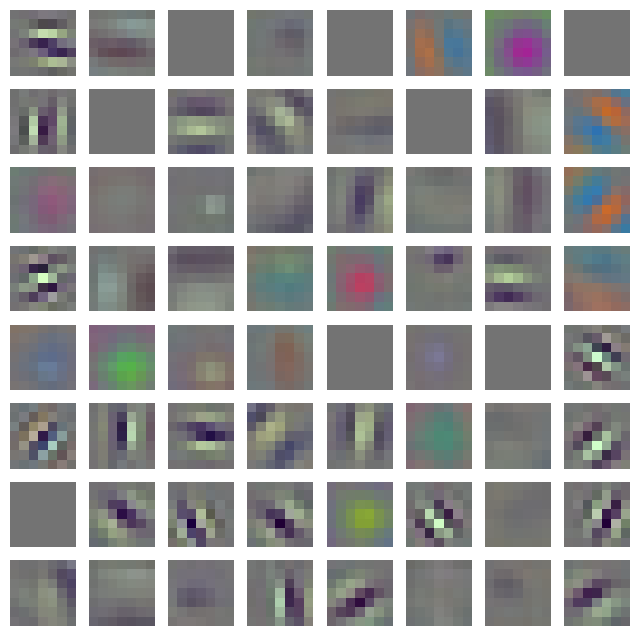

In [24]:
# filters for first layer of pretrained model
filters_pretrained = net_pretrained.conv1.weight.data.cpu().numpy() #Grabbing the first convolutional filters weights, moving them to the CPU, and turning them into a numpy tensor
visualizeFilters(filters_pretrained)

### Filters for the model trained from scratch

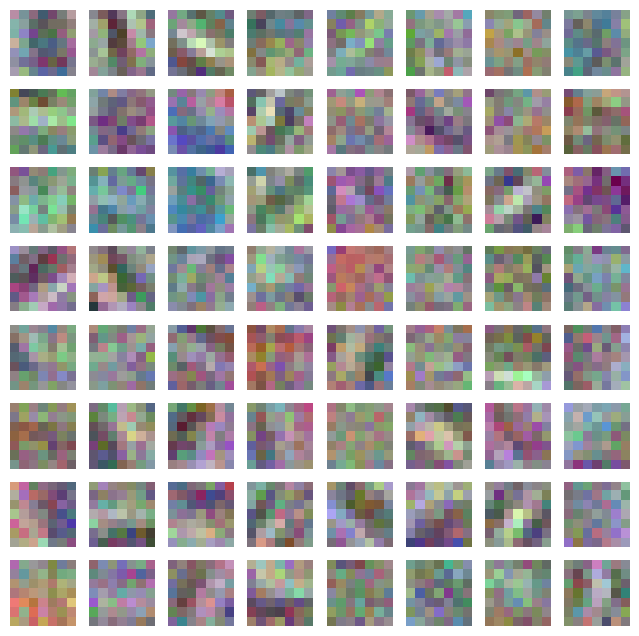

In [25]:
# filters for first layer of pretrained model
filters_from_scratch = net_train_from_scratch.conv1.weight.data.cpu().numpy() #Grabbing the first convolutional filters weights, moving them to the CPU, and turning them into a numpy tensor
visualizeFilters(filters_from_scratch)

### Filters for the finetuned model

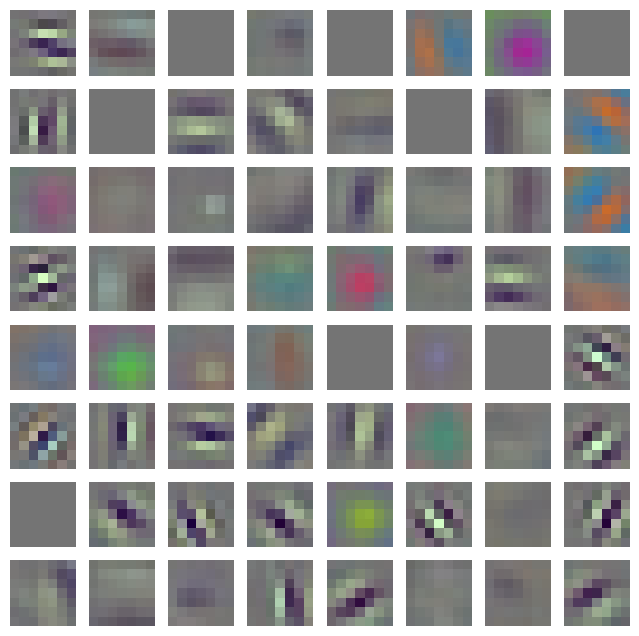

In [26]:
# filters for first layer of pretrained model
filters_finetuned = net_finetune.conv1.weight.data.cpu().numpy() #Grabbing the first convolutional filters weights, moving them to the CPU, and turning them into a numpy tensor
visualizeFilters(filters_finetuned)